# Datamining

In [1]:
SEED = 26062019

test_size = 0.5 

import sys
import numpy as np
import pandas as pd
from sklearn import __version__ as sk_vers
import matplotlib.pyplot as plt
from matplotlib import __version__ as m_vers
#import pickle
#from yellowbrick import __version__ as yb_vers
#import random
#from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
#import sklearn.ensemble as ske
#import re
#import xgboost as xgb
#import seaborn as sns


print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)

Current versions Modules:

Pandas version:		0.24.2
Matplotlib version:	3.1.0
numpy version:		1.16.4
sklearn version:	0.21.2


## Load data

In [2]:
df_mood = pd.read_csv(r'data/dataset_mood_smartphone.csv', sep=',', index_col=0)
print('nr of entries: ', len(df_mood))
df_mood['time'] = df_mood['time'].astype('datetime64[ns]')

df_mood.head()

nr of entries:  376912


,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00,mood,6.0
2,AS14.01,2014-02-26 15:00:00,mood,6.0
3,AS14.01,2014-02-26 18:00:00,mood,6.0
4,AS14.01,2014-02-26 21:00:00,mood,7.0
5,AS14.01,2014-02-27 09:00:00,mood,6.0


(5641, 5643, 5643, 22965, 96578, 5239, 1798, 91288, 74276, 27125, 939, 813, 5642, 7650, 19145, 2846, 939, 2487, 255)


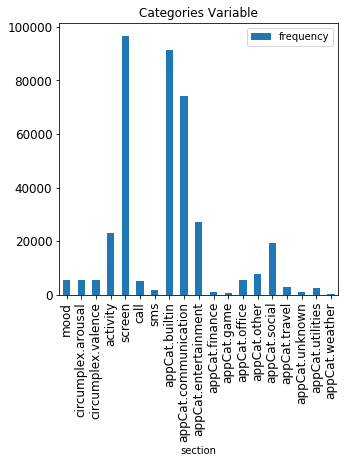

In [3]:
from collections import Counter

labels, values = zip(*Counter(df_mood['variable']).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Categories Variable", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)

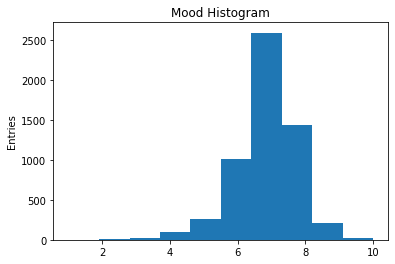

In [4]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='mood']

x = sub_mood['value']
plt.hist(x)
plt.gca().set(title='Mood Histogram', ylabel='Entries');

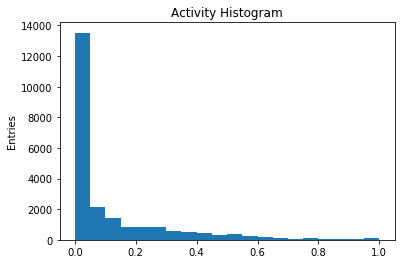

In [5]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='activity']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='Activity Histogram', ylabel='Entries');

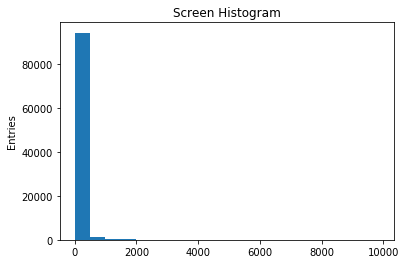

In [14]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='screen']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='Screen Histogram', ylabel='Entries');

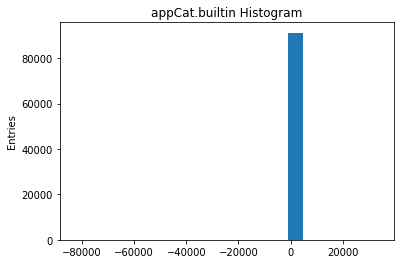

In [8]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='appCat.builtin']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='appCat.builtin Histogram', ylabel='Entries');

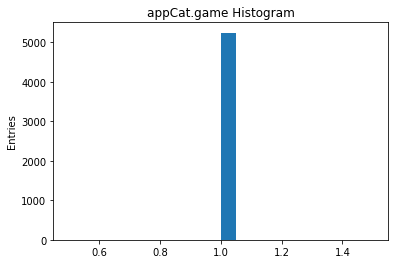

In [13]:
from collections import Counter

sub_mood = df_mood[df_mood['variable']=='call']

x = sub_mood['value']
plt.hist(x, bins=20)
plt.gca().set(title='appCat.game Histogram', ylabel='Entries');

In [12]:
print('Max: ', df_mood[df_mood['variable']=='appCat.builtin'].max())

Max:  id                             AS14.33
time        2014-06-08 11:04:46.335000
variable                appCat.builtin
value                          33960.2
dtype: object


In [5]:
print('Min: ', df_mood['value'].min())
print('Max: ', df_mood['value'].max())


Min:  -82798.871
Max:  33960.246


## Aggregate Data

### step 1: Count days since inclusion
This is an important step to prepare the data for time window aggregation.

In [125]:
class Aggregation(object):
    """
    Summary class:
        Aggregate the temporial data with a time window
        
        - key = id column, unique users
        - define the column with the timestamp
        - define the window size
    """
    def __init__(self, df, key, timestamp, window=5):
        self.df = df
        self.key = key
        self.window = window
        self.timestamp = timestamp
    
    def setDF(self):
        self.df = df
        
    def getDF(self):
        return self.df
    
    def formatTimeSpan(self):
        """
        Translate time stamps to time in days ever since inclusion of said user
        
        Translate informational absent single observation columns 
        to meaningful frequencies. (For example: sms & calls columns)
        
        """
        cols = list(self.df.keys())
        cols.append('days')
        df_new = pd.DataFrame(columns=cols)
        for subject in self.df[self.key].unique():
            df_sub = self.df[self.df[self.key]==subject]
            df_sub = self.countTheDays(df_sub)
            for day in range(df_sub['days'].max()):
                df_day = df_sub[df_sub['days']==day]
                nr_calls = len(df_day[df_day['variable']=='call'])
                #print(nr_calls)
                if nr_calls != 0:
                    df_calls = pd.DataFrame([pd.Series([df_day['id'].iloc[0], df_day['time'].iloc[0], 'total_calls', nr_calls, day])])
                    df_calls = df_calls.rename(columns={0: cols[0], 1: cols[1], 2: cols[2], 3: cols[3], 4: cols[4]})
                    #print(df_calls)
                    
                    df_sub = pd.concat([df_sub, df_calls], axis=0)
                nr_sms = len(df_day[df_day['variable']=='sms'])
                if nr_sms != 0:
                    df_sms = pd.DataFrame([pd.Series([df_day['id'].iloc[0], df_day['time'].iloc[0], 'total_sms', nr_sms, day])])
                    df_sms = df_sms.rename(columns={0: cols[0], 1: cols[1], 2: cols[2], 3: cols[3], 4: cols[4]})
                    df_sub = pd.concat([df_sub, df_sms], axis=0)
                if day not in list(df_sub['days'].unique()):
                    #print(day)
                    s = pd.DataFrame([pd.Series([df_sub['id'].iloc[0],np.nan,'mood',np.nan, day], index=cols)])
                    df_sub = pd.concat([df_sub, s], axis=0, ignore_index=True)# df_sub.append(s, ignore_index=True)
            df_new = pd.concat([df_new, df_sub])
        self.df = df_new
        
    def countTheDays(self, df_sub):
        initial_date = df_sub[self.timestamp].min()
        df_sub['days'] = pd.to_datetime(df_sub[self.timestamp]).sub(initial_date).dt.days
        return df_sub
    
agg = Aggregation(df_mood, 'id', 'time', window=5)
agg.formatTimeSpan()
temp_df = agg.getDF()
temp_df.head()

C:\Users\levrex\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,time,variable,value,days
0,AS14.01,2014-02-26 13:00:00,mood,6.0,9
1,AS14.01,2014-02-26 15:00:00,mood,6.0,9
2,AS14.01,2014-02-26 18:00:00,mood,6.0,9
3,AS14.01,2014-02-26 21:00:00,mood,7.0,9
4,AS14.01,2014-02-27 09:00:00,mood,6.0,9


In [126]:
temp_df[temp_df['id']=='AS14.01'].sort_values('days')

,id,time,variable,value,days
7162,AS14.01,2014-02-17 12:04:42.394,call,1.000,0
7164,AS14.01,2014-02-18 09:29:51.257,call,1.000,0
21999,AS14.01,2014-02-17 12:04:42.394,total_calls,3.000,0
7163,AS14.01,2014-02-17 18:28:25.520,call,1.000,0
22000,AS14.01,NaT,mood,NaN,1
22001,AS14.01,2014-02-19 14:43:30.575,total_calls,7.000,2
7317,AS14.01,2014-02-20 11:16:45.930,sms,1.000,2
7316,AS14.01,2014-02-20 11:13:44.448,sms,1.000,2
7315,AS14.01,2014-02-20 10:58:33.924,sms,1.000,2
7313,AS14.01,2014-02-19 17:42:34.292,sms,1.000,2


In [127]:
print(len(temp_df))
print(len(temp_df[((temp_df['variable']!='call') &(temp_df['variable']!='sms'))]))

379176
372139


## Transform from Long to Wide

In [133]:
temp_df_unstack = temp_df.groupby(['id', 'days','variable'])['value'].median().unstack('variable')

In [157]:
rolling_df = temp_df_unstack[['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.other', 'appCat.social', 'appCat.travel',
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen',
       'total_calls', 'total_sms']]

In [158]:
rolling_df = rolling_df.reset_index(level=1, drop=False)
#rolling_df = rolling_df.reset_index(level=0, drop=False)
rolling_df = rolling_df.rolling(5).agg({'activity':'mean', 'appCat.builtin':'mean', 'appCat.communication':'mean','appCat.entertainment':'mean', 
                           'appCat.other':'mean','appCat.social':'mean', 'appCat.travel':'mean', 'circumplex.arousal':'mean',  
                           'circumplex.valence':'mean',  'mood':'mean',  'screen':'mean',  'total_calls':'mean',  'total_sms':'mean'})
rolling_df.head()

,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social,appCat.travel,circumplex.arousal,circumplex.valence,mood,screen,total_calls,total_sms
id,,,,,,,,,,,,,
AS14.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AS14.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AS14.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AS14.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AS14.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
rolling_df = temp_df_unstack[['activity', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.utilities', 'appCat.weather', 
       'circumplex.arousal', 'circumplex.valence', 'mood', 'screen',
       'total_calls', 'total_sms']]

In [79]:
import seaborn as sns

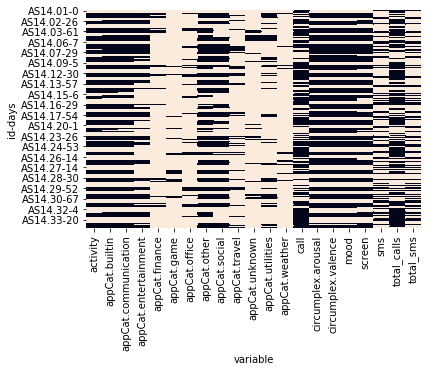

In [130]:
sns.heatmap(temp_df_unstack.head(10000).isnull(), cbar=False)

In [53]:
temp_df.tail()

,id,time,variable,value,days
0,AS14.33,2014-04-11 18:27:20.875,total_sms,1.0,53
0,AS14.33,2014-04-15 09:02:04.727,total_calls,1.0,56
0,AS14.33,2014-04-15 09:02:04.727,total_sms,1.0,56
0,AS14.33,2014-04-15 09:02:04.727,total_calls,1.0,56
0,AS14.33,2014-03-15 14:22:33.002,total_sms,1.0,25


In [7]:
temp_df[temp_df['variable']=='screen'].head()

,id,time,variable,value,days
39893,AS14.01,2014-03-20 23:14:58.200,screen,58.846,31
39894,AS14.01,2014-03-20 23:17:23.092,screen,9.217,31
39895,AS14.01,2014-03-20 23:20:43.698,screen,19.829,31
39896,AS14.01,2014-03-20 23:22:05.476,screen,483.510,31
39897,AS14.01,2014-03-20 23:31:08.088,screen,812.907,31


In [16]:
# remove negative outliers
temp_df = temp_df[((temp_df['variable']!='appCat.builtin') | (temp_df['value']>0))]
#temp_df[temp_df['variable']=='screen']

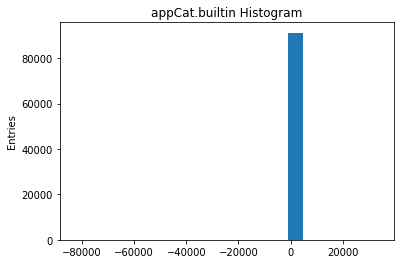

In [15]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler  # scale time features

In [88]:

df_mood[((df_mood['value']>10.0)&(df_mood['variable']=='mood'))]

,id,time,variable,value
